# 样式迁移

样式迁移
- 将样式图片中的样式迁移到内容图片上，得到合成图片

奠基性工作
- 基于CNN的样式迁移

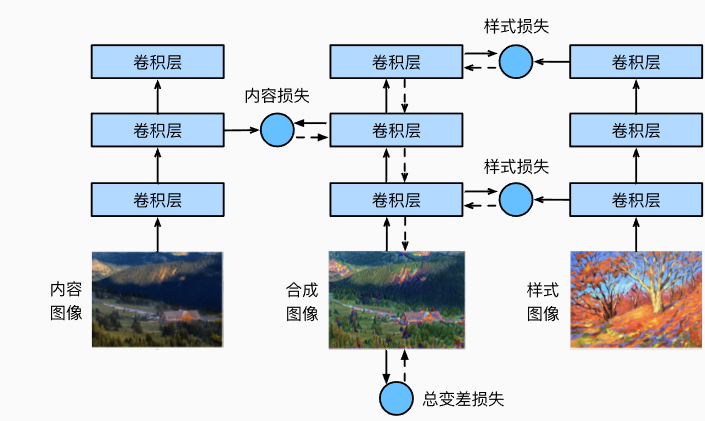

样式迁移常用的损失函数由3部分组成：
- 内容损失使合成图像与内容图像在内容特征上接近
- 风格损失使合成图像与风格图像在风格特征上接近
- 全变分损失有助于减少合成图像中的噪点

In [15]:
#导入第三方库
%matplotlib inline
import torch, torchvision
from torch import nn
from d2l import torch as d2l

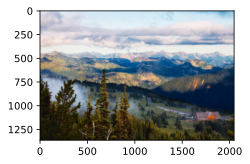

In [16]:
#读取原始图片
d2l.set_figsize()
content_img = d2l.Image.open('../img/rainier.jpg')
d2l.plt.imshow(content_img)

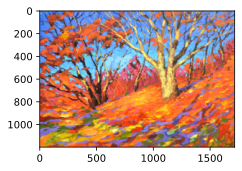

In [17]:
#读取样式图片
d2l.set_figsize()
style_img = d2l.Image.open('../img/autumn-oak.jpg')
d2l.plt.imshow(style_img)

In [18]:
#对图像进行预处理和后处理
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

def preprocess(img, img_shape):
    """对原始图像的三个通道(R,G,B)进行标准化处理"""
    transforms = torchvision.transforms.Compose([
        #重新制定图像尺寸大小
        torchvision.transforms.Resize(img_shape),
        #转换为张量形式
        torchvision.transforms.ToTensor(),
        #对图像进行标准化处理
        torchvision.transforms.Normalize(mean= rgb_mean, std= rgb_std)])
    return transforms(img).unsqueeze(0)

def postprocess(img):
    img = img[0].to(rgb_std.device)
    img = torch.clamp(img.permute(1, 2, 0)* rgb_std + rgb_mean, 0, 1)
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

In [19]:
#使用基于ImagNet数据集预训练的VGG19来抽取图像特征
pretrained_net = torchvision.models.vgg19(pretrained= True)

In [20]:
#选取VGG模型中的某些层来抽取图像的内容特征和风格特征
#直接从0层构建到最大目标层的子网络
style_layers, content_layers = [0, 5, 10, 19, 28], [25]
#使用容器构建自己的网络
net = nn.Sequential(*[pretrained_net.features[i] for i in 
                    range(max(style_layers + style_layers) + 1)])

In [21]:
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

In [22]:
#对内容图像抽取内容特征
def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape).to(device)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).to(device)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

In [23]:
#定义损失函数
#内容损失函数
def content_loss(Y_hat, Y):
    #从动态计算梯度树中分离目标
    return torch.square(Y_hat - Y.detach()).mean()
#风格损失函数
#定义格拉姆矩阵的计算
def gram(X):
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    X = X.reshape((num_channels, n))
    return torch.matmul(X, X.T) / (num_channels * n)
#风格损失函数
def style_loss(Y_hat, gram_Y):
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()
#全变分损失：尽可能使邻近像素相似
def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

In [24]:
#样式迁移的损失函数即为内容损失、风格损失和总变化损失的加权和
#通过调节这些权重超参数，我们可以权衡合成图像在保留内容、迁移风格以及去噪三方面的相对重要性。
content_weight, style_weight, tv_weight = 1, 1e4, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # 分别计算内容损失、风格损失和全变分损失
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # 对所有损失求和
    l = sum(styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

In [25]:
#初始化合成图像
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        #随机初始化模型权重
        self.weight = nn.Parameter(torch.rand(*img_shape))
    
    def forward(self):
        """返回初始化权重"""
        return self.weight

def get_inits(X, device, lr, styles_Y):
    """创建合成图像的模型实例并将其初始化"""
    gen_img = SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)
    trainer = torch.optim.Adam(gen_img.parameters(), lr= lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

In [26]:
#训练模型
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs],
                            legend=['content', 'style', 'TV'],
                            ncols=2, figsize=(7, 2.5))
    for epoch in range(num_epochs):
        trainer.zero_grad()
        contents_Y_hat, styles_Y_hat = extract_features(
            X, content_layers, style_layers)
        contents_l, styles_l, tv_l, l = compute_loss(
            X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward(retain_graph= True)
        trainer.step()
        scheduler.step()
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(epoch + 1, [float(sum(contents_l)),
                                     float(sum(styles_l)), float(tv_l)])
    return X

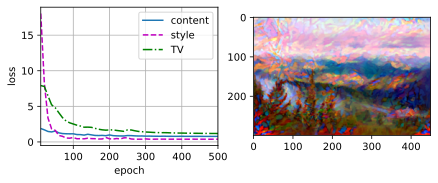

In [27]:
device, image_shape = d2l.try_gpu(), (300, 450)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)